In [ ]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

In [425]:
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange', 
    'drug': 'tab:green',
    'cytokine': 'tab:olive'
}
SDIR = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
table_path = '/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/'

In [426]:
#looks really cool for 
cool_ones = ['PapalexiSatija2021_eccite_RNA', 'TianKampmann2021_CRISPRa', 'TianKampmann2021_CRISPRi', 'NormanWeissman2019_filtered',
             'SrivatsanTrapnell2020_sciplex3', 'DixitRegev2016', 'DatlingerBock2017', 'FrangiehIzar2021_RNA', 'ShifrutMarson2018']  # SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen

In [135]:
pwd = pairwise_distances(adata.obsm['X_pca'], metric='sqeuclidean')
adata.obsp['pwd'] = pwd

In [315]:
def edist(adata, obs_key, control='control', obsp_key='pwd'):
    '''
    Computes the edistance to control. Accepts precomputed pwd.
    '''
    pwd = adata.obsp[obsp_key]
    groups = pd.unique(adata.obs[obs_key])
    df = pd.DataFrame(index=groups, columns=['delta', 'sigma'], dtype=float)
    p1 = control
    x1 = adata.obs[obs_key]==p1
    N = np.sum(x1)
    for p2 in groups:
        x2 = adata.obs[obs_key]==p2
        M = np.sum(x2)
        # delta
        spwd = pwd[x1, :][:, x2]  # [x1, x2]
        mean_pwd = np.sum(spwd) / (N*M - N * (p1==p2))
        df.loc[p2, 'delta'] = mean_pwd
        # sigma
        spwd = pwd[x2, :][:, x2]  # [x2, x2]
        mean_pwd = np.sum(spwd) / (M**2 - M)
        df.loc[p2, 'sigma'] = mean_pwd
    sigmas = df.sigma
    deltas = df.delta
    df['edist'] = 2 * deltas - sigmas - sigmas.loc['control']
    return df

In [318]:
def etest(adata, obs_key='perturbation', obsm_key='X_pca', metric='sqeuclidean', runs=100):
    if 'pwd' not in adata.obsp.keys():
        adata.obsp['pwd'] = pairwise_distances(adata.obsm[obsm_key], metric=metric)
    res = []
    groups = pd.unique(adata.obs[obs_key])
    for i in tqdm(range(runs), leave=False):
        # per perturbation, shuffle with control and compute e-distance
        df = pd.DataFrame(index=groups, columns=['delta', 'sigma', 'edist'], dtype=float)
        for group in groups:
            if group=='control':
                df.loc[group] = [0, 0, 0]
                continue
            mask = adata.obs[obs_key].isin([group, 'control'])
            subdata = adata[mask].copy()
            subdata.obs['shuffled'] = np.random.permutation(subdata.obs[obs_key].values)
            df_ = edist(subdata, 'shuffled')
            df.loc[group] = df_.loc[group]
        res.append(df.sort_index())
    
    # without shuffling
    df = edist(adata, obs_key)
    df = df.sort_index()

    # test
    results = pd.concat([r['edist'] - df['edist'] for r in res], axis=1) > 0  # count times shuffling resulted in larger e-distance
    pvalues = np.sum(results, axis=1) / runs  # average

    # aggregate
    tab = pd.concat([df['edist'], pvalues], axis=1)
    tab.columns = ['edist', 'pvalue']
    return tab

In [321]:
tab = etest(adata, runs=10)

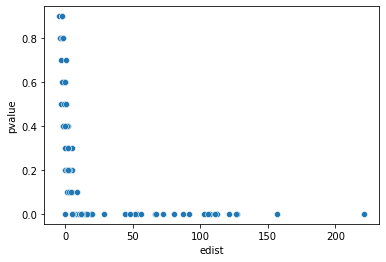

In [322]:
sns.scatterplot(data=tab, x='edist', y='pvalue');

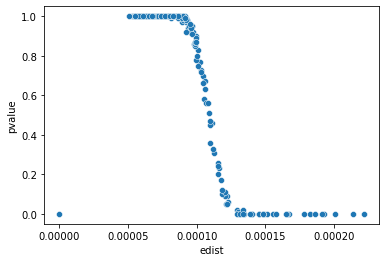

In [96]:
sns.scatterplot(data=tab, x='edist', y='pvalue');

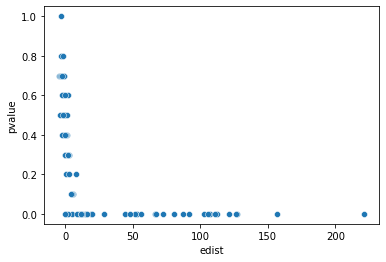

In [327]:
key='PapalexiSatija2021_eccite_RNA'
adata = sc.read(SDIR+'tmp_data_' + key + '.h5')
tab = etest(adata, runs=10)
sns.scatterplot(data=tab, x='edist', y='pvalue');

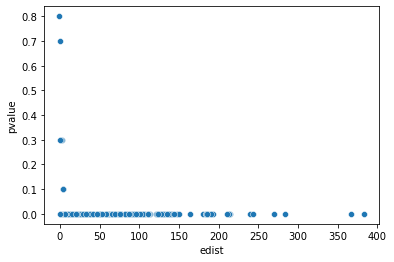

In [328]:
key = 'NormanWeissman2019_filtered'
adata = sc.read(SDIR+'tmp_data_' + key + '.h5')
tab = etest(adata, runs=10)
sns.scatterplot(data=tab, x='edist', y='pvalue');

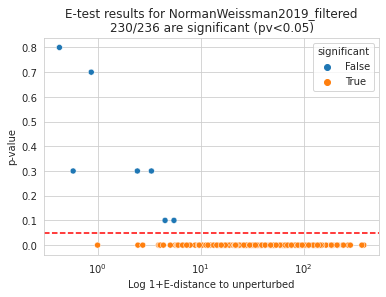

In [356]:
pseudocount = 1
tab['significant'] = tab.pvalue < 0.05
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=tab, x=tab.edist+pseudocount, y=tab.pvalue, hue='significant')
pl.xlabel(f'Log {pseudocount}+E-distance to unperturbed')
sig = np.sum(tab['significant'])
total = len(tab)-1
pl.title(f'E-test results for {key}\n{sig}/{total} are significant (pv<0.05)')
pl.xscale('log')
pl.ylabel('p-value')
pl.axhline(0.05, c='r', linestyle='--')
pl.show()

In [6]:
pairs_all = pd.concat(pairs_datasets)
pairs_all['E-statistic'] = ['perturbed-unperturbed' if 'control' in x+y else 'perturbed-perturbed' for x,y in zip(pairs_all.level_0, pairs_all.level_1)]
pairs_all['pair'] = [x+'-'+y for x,y in zip(pairs_all.level_0, pairs_all.level_1)]
pairs_all['dataset_pretty'] = [x.replace('_', '\n', 1) for x in pairs_all.dataset]

In [7]:
key = 'NormanWeissman2019_filtered'
pairs = pairs_datasets[key]
estats = estats_datasets[key]
estats_control = pd.DataFrame(estats.loc[:, 'control'])
estats_control.columns=['E-statistic']

# re-plot results from snakemake

In [374]:
tab.head()

,edist,pvalue,significant
AHR,27.191157,0.0,True
AHR_FEV,128.476686,0.0,True
AHR_KLF1,28.096626,0.0,True
ARID1A,57.577350,0.0,True
ARRDC3,13.940715,0.0,True


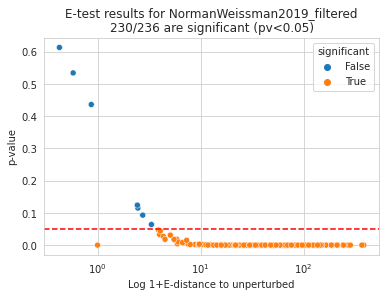

In [375]:
pseudocount = 1
tab['significant'] = tab.pvalue < 0.05
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=tab, x=tab.edist+pseudocount, y=tab.pvalue, hue='significant')
pl.xlabel(f'Log {pseudocount}+E-distance to unperturbed')
sig = np.sum(tab['significant'])
total = len(tab)-1
pl.title(f'E-test results for {key}\n{sig}/{total} are significant (pv<0.05)')
pl.xscale('log')
pl.ylabel('p-value')
pl.axhline(0.05, c='r', linestyle='--')
pl.show()

In [376]:
from statsmodels.stats.multitest import multipletests

In [419]:
for key in cool_ones:
    try:
        tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
    except:
        continue
    tab = tab[tab.index!='control']
    significant, pvalue_adj, _, _ = multipletests(tab.pvalue, alpha=0.05, method='holm-sidak')
    tab['pvalue_adj'] = pvalue_adj
    tab['significant_adj'] = significant
    with sns.axes_style('whitegrid'):
        tab['tmp'] = np.clip(tab.edist, pseudocount, np.infty)
        sns.scatterplot(data=tab, x='tmp', y=tab.pvalue_adj, hue='significant_adj')
    pl.xlabel(f'Log E-distance to unperturbed')
    sig = np.sum(tab['significant_adj'])
    total = len(tab)
    pl.title(f'E-test results for {key}\n{sig}/{total} are significant (pv<0.05)')
    pl.xscale('log')
    pl.ylabel('p-value')
    pl.axhline(0.05, c='r', linestyle='--')
    pl.show()

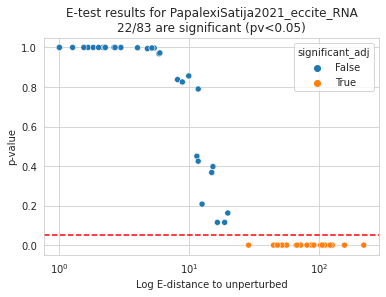

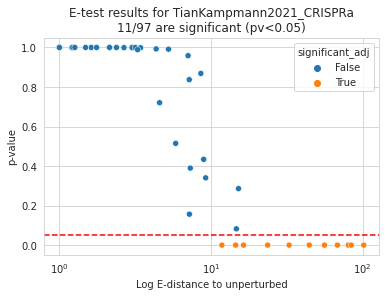

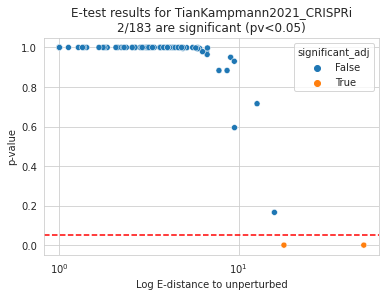

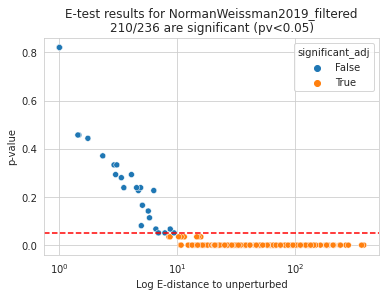

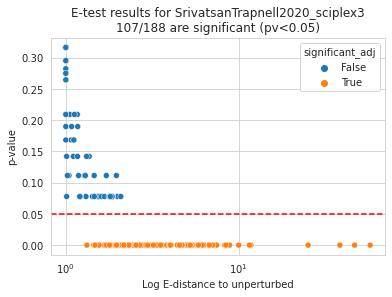

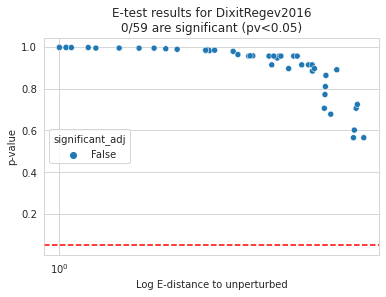

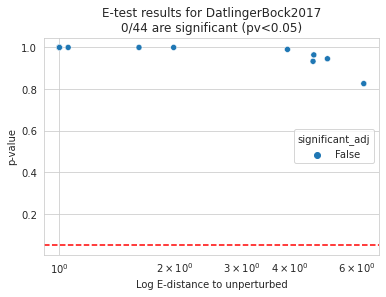

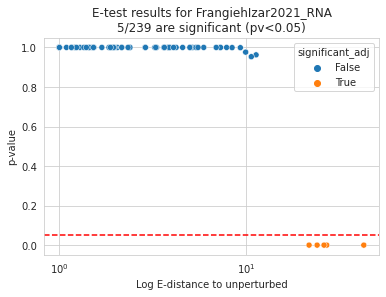

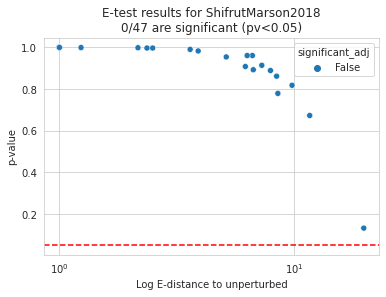

In [414]:
for key in cool_ones:
    try:
        tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
    except:
        continue
    tab = tab[tab.index!='control']
    significant, pvalue_adj, _, _ = multipletests(tab.pvalue, alpha=0.05, method='holm-sidak')
    tab['pvalue_adj'] = pvalue_adj
    tab['significant_adj'] = significant
    with sns.axes_style('whitegrid'):
        tab['tmp'] = np.clip(tab.edist, pseudocount, np.infty)
        sns.scatterplot(data=tab, x='tmp', y=tab.pvalue_adj, hue='significant_adj')
    pl.xlabel(f'Log E-distance to unperturbed')
    sig = np.sum(tab['significant_adj'])
    total = len(tab)
    pl.title(f'E-test results for {key}\n{sig}/{total} are significant (pv<0.05)')
    pl.xscale('log')
    pl.ylabel('p-value')
    pl.axhline(0.05, c='r', linestyle='--')
    pl.show()

In [406]:
res = {}
for key in cool_ones:
    try:
        tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
    except:
        continue
    tab = tab[tab.index!='control']
    significant, pvalue_adj, _, _ = multipletests(tab.pvalue, alpha=0.05, method='holm-sidak')
    tab['pvalue_adj'] = pvalue_adj
    tab['significant_adj'] = significant
    res[key] = np.sum(significant) / len(significant)

In [408]:
pd.Series(res)

PapalexiSatija2021_eccite_RNA     0.265060
TianKampmann2021_CRISPRa          0.113402
TianKampmann2021_CRISPRi          0.010929
NormanWeissman2019_filtered       0.889831
SrivatsanTrapnell2020_sciplex3    0.569149
DixitRegev2016                    0.000000
DatlingerBock2017                 0.000000
FrangiehIzar2021_RNA              0.020921
ShifrutMarson2018                 0.000000
dtype: float64

In [410]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']

datasets = list(h5_files.keys())

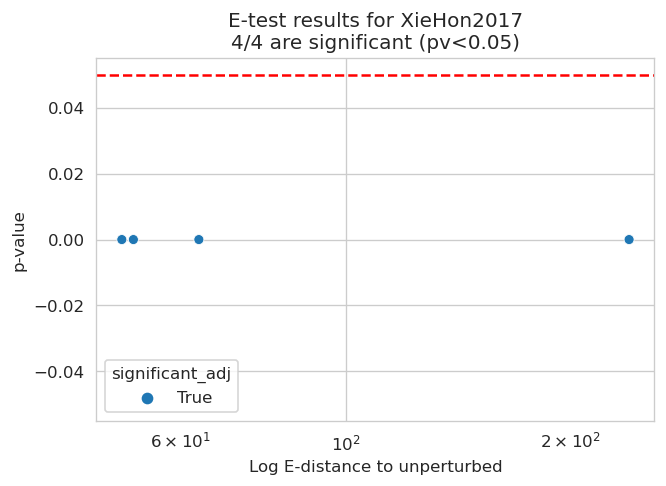

In [421]:
res = {}
for key in datasets:
    try:
        tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
    except:
        continue
    tab = tab[tab.index!='control']
    significant, pvalue_adj, _, _ = multipletests(tab.pvalue, alpha=0.05, method='holm-sidak')
    tab['pvalue_adj'] = pvalue_adj
    tab['significant_adj'] = significant
    with sns.axes_style('whitegrid'):
        pl.figure(dpi=120)
        tab['tmp'] = np.clip(tab.edist, pseudocount, np.infty)
        sns.scatterplot(data=tab, x='tmp', y=tab.pvalue_adj, hue='significant_adj')
    pl.xlabel(f'Log E-distance to unperturbed')
    sig = np.sum(tab['significant_adj'])
    total = len(tab)
    pl.title(f'E-test results for {key}\n{sig}/{total} are significant (pv<0.05)')
    pl.xscale('log')
    pl.ylabel('p-value')
    pl.axhline(0.05, c='r', linestyle='--')
    pl.show()
    res[key] = np.sum(significant) / len(significant)

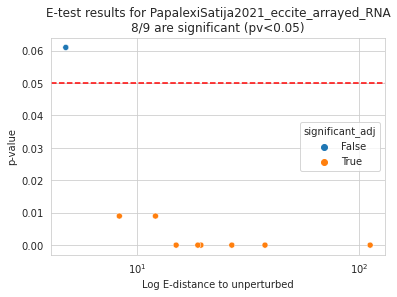

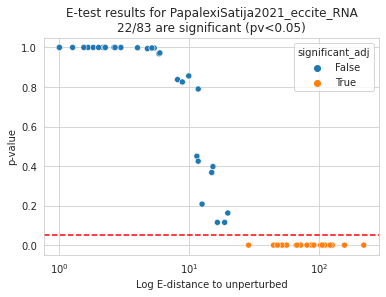

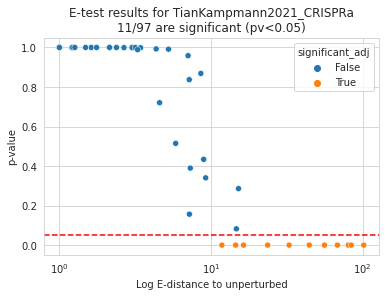

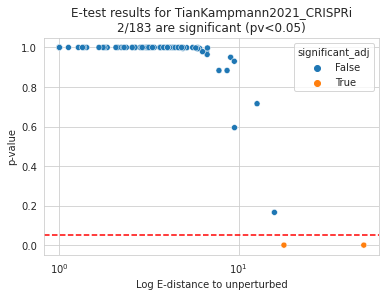

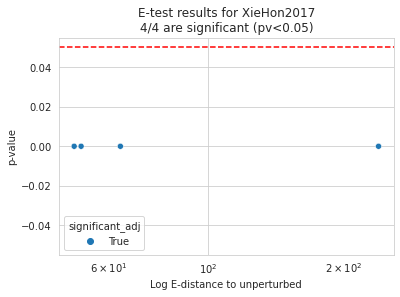

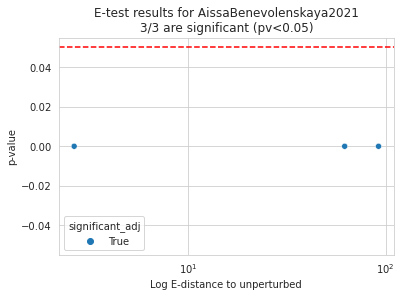

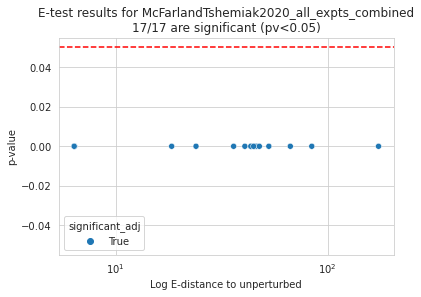

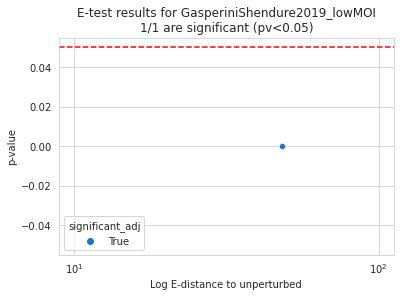

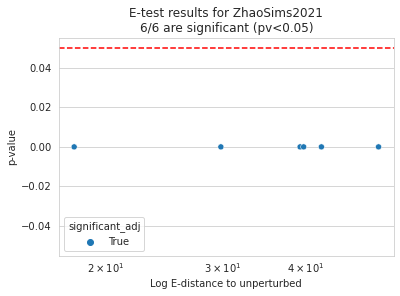

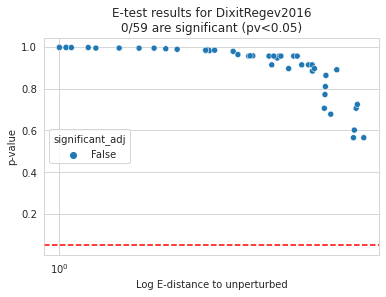

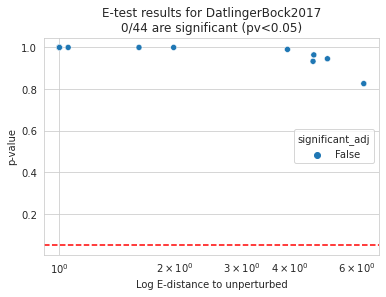

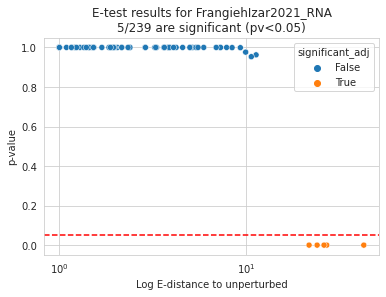

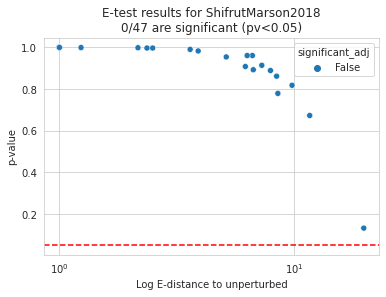

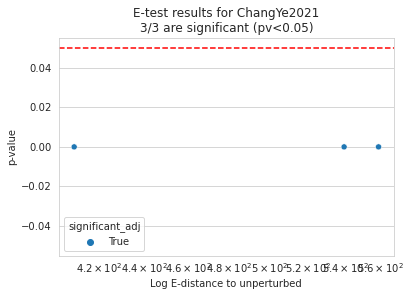

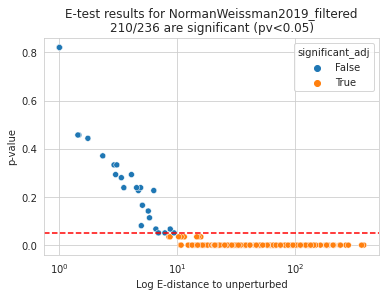

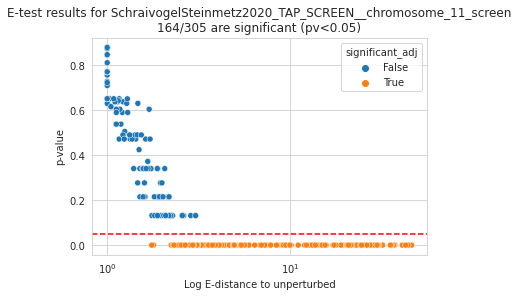

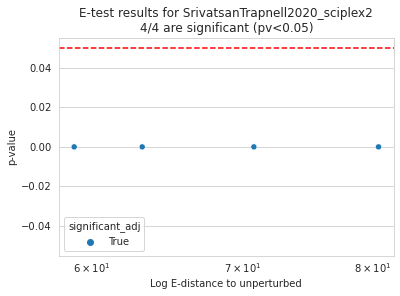

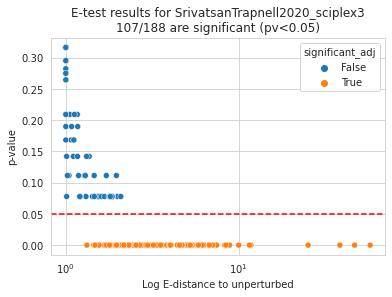

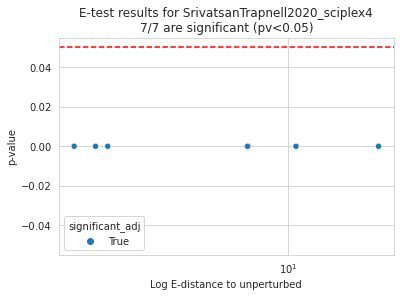

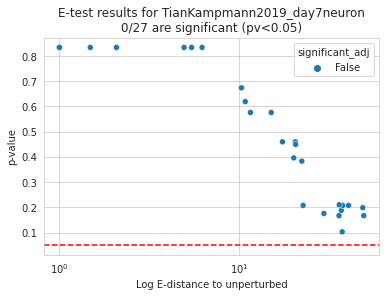

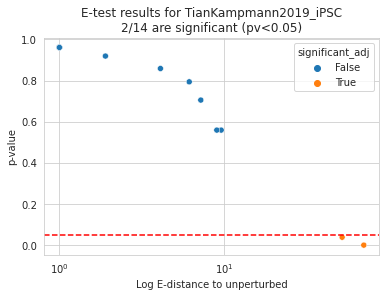

In [415]:
res = {}
for key in datasets:
    try:
        tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
    except:
        continue
    tab = tab[tab.index!='control']
    significant, pvalue_adj, _, _ = multipletests(tab.pvalue, alpha=0.05, method='holm-sidak')
    tab['pvalue_adj'] = pvalue_adj
    tab['significant_adj'] = significant
    with sns.axes_style('whitegrid'):
        tab['tmp'] = np.clip(tab.edist, pseudocount, np.infty)
        sns.scatterplot(data=tab, x='tmp', y=tab.pvalue_adj, hue='significant_adj')
    pl.xlabel(f'Log E-distance to unperturbed')
    sig = np.sum(tab['significant_adj'])
    total = len(tab)
    pl.title(f'E-test results for {key}\n{sig}/{total} are significant (pv<0.05)')
    pl.xscale('log')
    pl.ylabel('p-value')
    pl.axhline(0.05, c='r', linestyle='--')
    pl.show()
    res[key] = np.sum(significant) / len(significant)

In [417]:
# % significant perturbations per dataset
pd.Series(res).sort_values()

DatlingerBock2017                                            0.000000
ShifrutMarson2018                                            0.000000
TianKampmann2019_day7neuron                                  0.000000
DixitRegev2016                                               0.000000
TianKampmann2021_CRISPRi                                     0.010929
FrangiehIzar2021_RNA                                         0.020921
TianKampmann2021_CRISPRa                                     0.113402
TianKampmann2019_iPSC                                        0.142857
PapalexiSatija2021_eccite_RNA                                0.265060
SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen    0.537705
SrivatsanTrapnell2020_sciplex3                               0.569149
PapalexiSatija2021_eccite_arrayed_RNA                        0.888889
NormanWeissman2019_filtered                                  0.889831
ZhaoSims2021                                                 1.000000
McFarlandTshemiak202

In [ ]:
# idea: could check if significance correlates with either counts per cell or cells per perturbation

# Spacers